In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict

In [3]:
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis.resonator.lmfit_resonator import LinearResonatorWithCable, LinearLossResonatorWithCable

In [4]:
npd = npy.NumpyDirectory('/data/detectors/2017-02-27_143510_temperature_fine.npd/')

In [5]:
swp_list = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweep') and not 'Stream' in name]
sss_list = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweepStream')]
snap_list = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]
print([(snap.x.ptp(), snap.y.ptp()) for snap in snap_list])

[(66.0, 105.0), (52.0, 74.0), (26.0, 39.0), (123.0, 126.0), (54.0, 57.0), (32.0, 34.0), (71.0, 70.0), (38.0, 37.0), (26.0, 24.0), (72.0, 80.0), (33.0, 35.0), (20.0, 24.0), (66.0, 66.0), (39.0, 39.0), (25.0, 26.0), (64.0, 61.0), (36.0, 36.0), (24.0, 24.0), (16.0, 18.0), (13.0, 12.0), (10.0, 10.0)]


In [6]:
swp_dict = defaultdict(list)
sss_dict = defaultdict(list)
for swp, sss in zip(swp_list, sss_list):
    swp_dict[sss.state.lo_index].append(swp)
    sss_dict[sss.state.lo_index].append(sss)

In [7]:
num_channels = len(sss_dict.keys())
num_attenuations = np.max([len(list_) for list_ in sss_dict.values()])

# Resonator model

In [8]:
for swp in swp_list:
    swp.fit_resonator(model=LinearResonatorWithCable)
for sss in sss_list:
    sss.sweep.fit_resonator(model=LinearResonatorWithCable)

# Tone centering

In [9]:
assert np.all([sss.stream.tone_offset_frequency()[sss.stream.tone_index] == 0 for sss in sss_list])

# Forward scattering versus frequency

In [10]:
s21_vs_f = {'xlabel': 'frequency / MHz',
            'ylabel': '$|S_{21}|^2$ / dB',
            'title': r'{:d}, {:.1f} dB: $Q_i = {:.0f}, \; Q_c = {:.0f}$'}

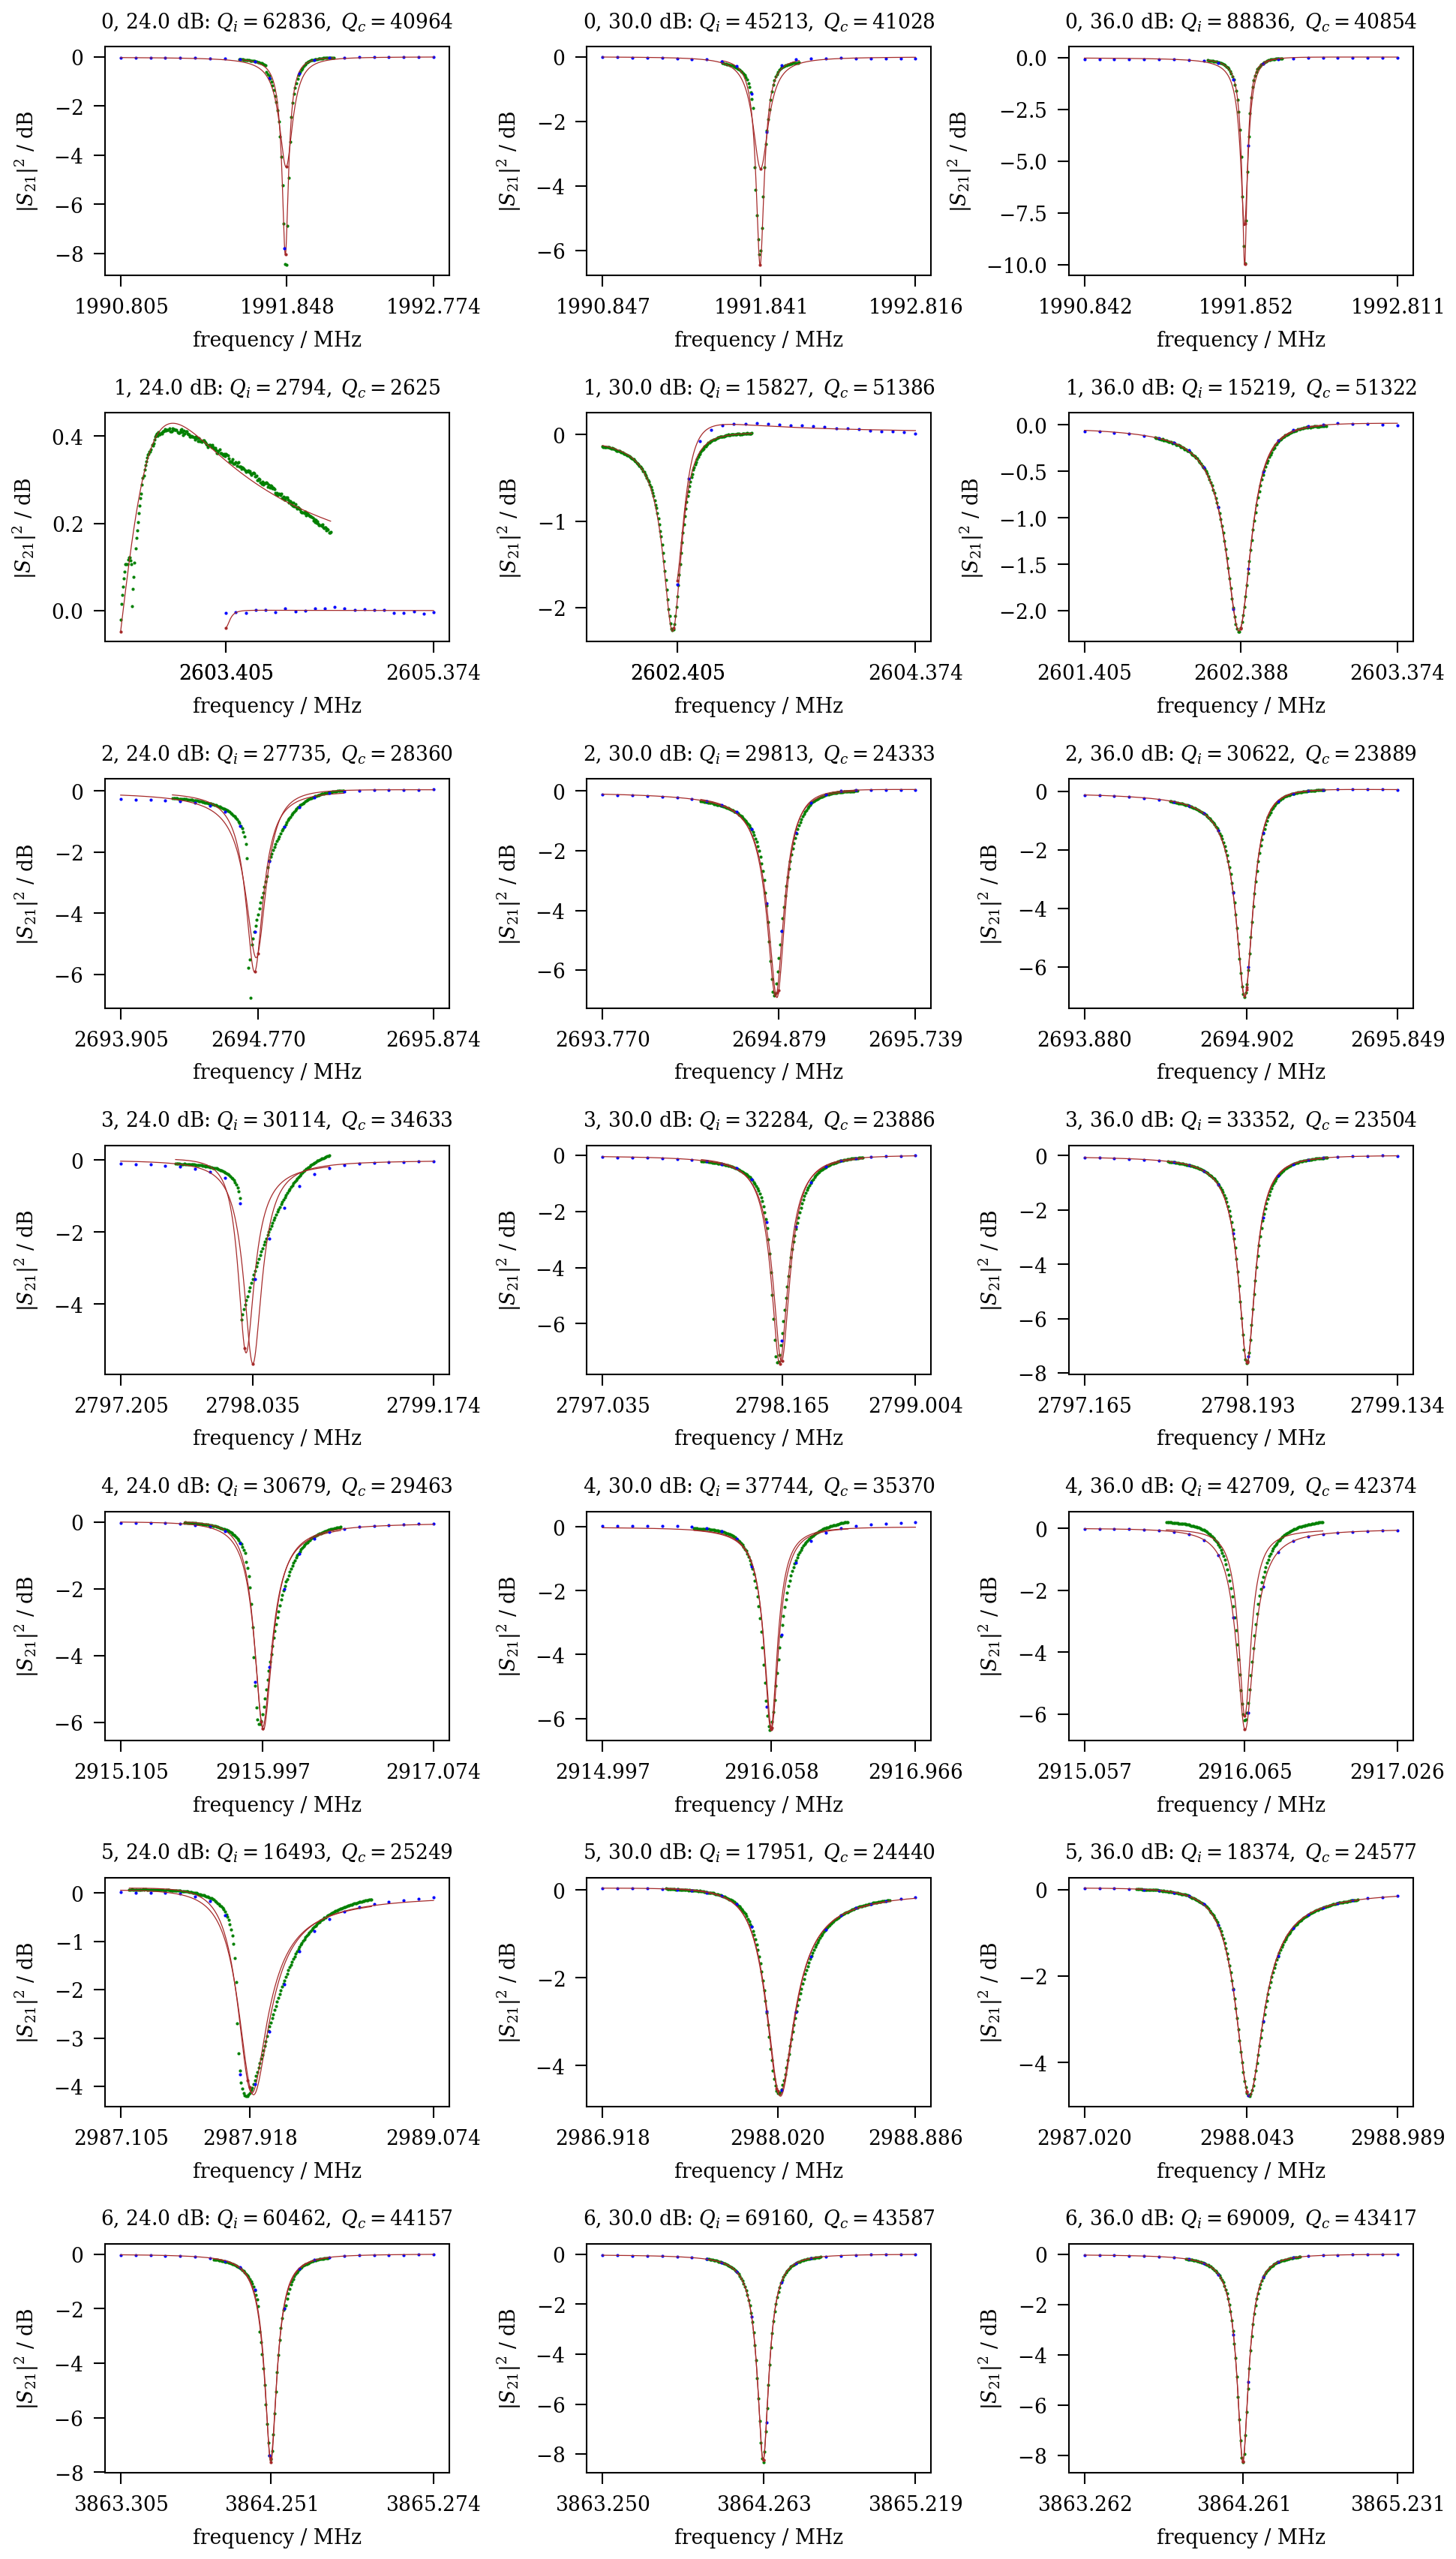

In [11]:
fig, axes = plt.subplots(len(sss_dict.keys()), num_attenuations,
                         figsize=(2.5 * num_attenuations, 2 * len(sss_dict.keys())),
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
for lo_index in sss_dict.keys():
    for swp, sss, ax in zip(swp_dict[lo_index], sss_dict[lo_index], axes[lo_index, :]):
        ax.tick_params(labelsize='xx-small')
        ax.set_xlabel(s21_vs_f['xlabel'], fontsize='xx-small')
        ax.set_ylabel(s21_vs_f['ylabel'], fontsize='xx-small')
        plot_basic.resonator_amplitude(sss.resonator, ax, normalize=True, sweep_mean_settings={'color': 'green'})
        plot_basic.resonator_amplitude(swp.resonator, ax, normalize=True)
        ax.set_title(s21_vs_f['title'].format(
            lo_index, sss.stream.roach_state.dac_attenuation, sss.resonator.Q_i, sss.resonator.Q_e_real),
                     fontsize='xx-small')

# Forward scattering in the complex plane

In [12]:
s21_complex = {'xlabel': 'Re $S_{21}$',
               'ylabel': 'Im $S_{21}$',
               'title': r'{:d}, {:.1f} dB: $Q_i = {:.0f}, \; Q_c = {:.0f}$'}

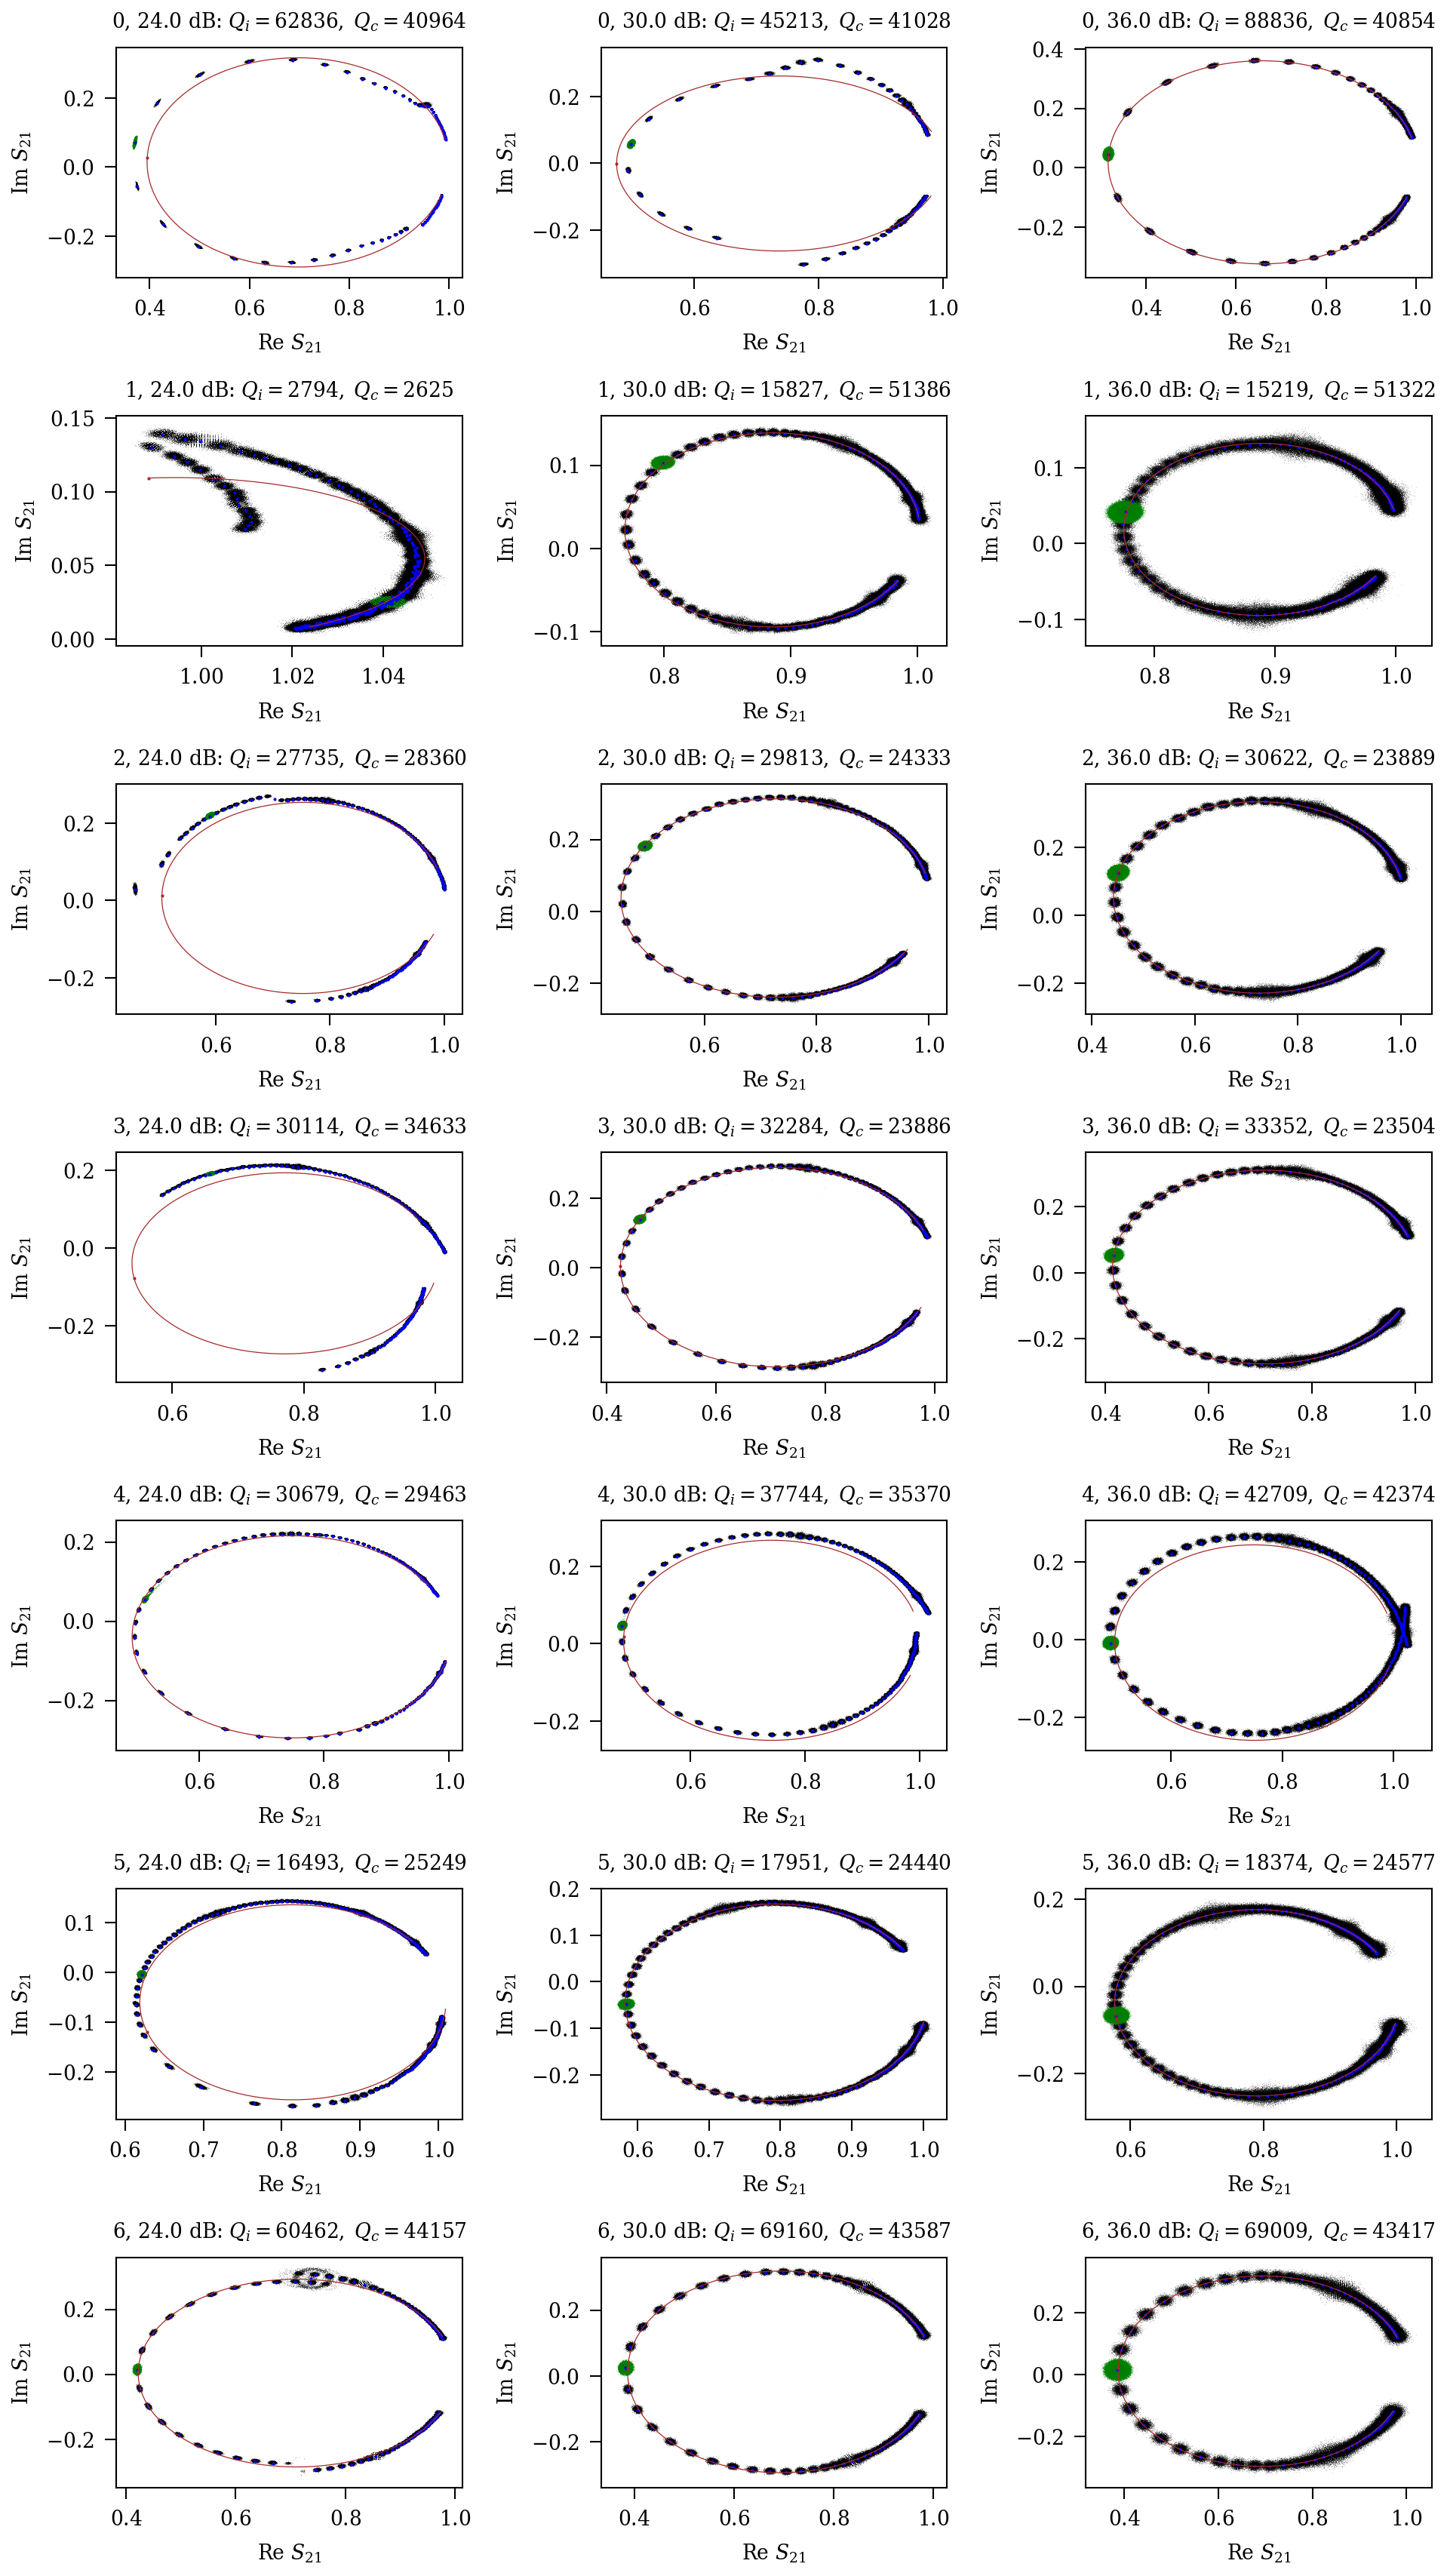

In [13]:
fig, axes = plt.subplots(len(sss_dict.keys()), num_attenuations,
                         figsize=(2.5 * num_attenuations, 2 * len(sss_dict.keys())),
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
for lo_index in sss_dict.keys():
    for swp, sss, ax in zip(swp_dict[lo_index], sss_dict[lo_index], axes[lo_index, :]):
        ax.tick_params(labelsize='xx-small')
        ax.set_xlabel(s21_complex['xlabel'], fontsize='xx-small')
        ax.set_ylabel(s21_complex['ylabel'], fontsize='xx-small')
        plot_basic.sss_complex_plane(sss, ax, normalize=True)
        ax.set_title(s21_complex['title'].format(
            lo_index, sss.stream.roach_state.dac_attenuation, sss.resonator.Q_i, sss.resonator.Q_e_real),
                     fontsize='xx-small')

# $S_{xx}$ and $S_{yy}$

In [14]:
xx_and_yy = {'xlabel': 'frequency / Hz',
             'ylabel': 'spectral density / Hz$^{-1}$',
             'title': r'{:d}, {:.1f} dB: $Q_i = {:.0f}, \; Q_c = {:.0f}$',
             'Sxx_label': '$S_{xx}$',
             'Syy_label': '$S_{yy}$'}

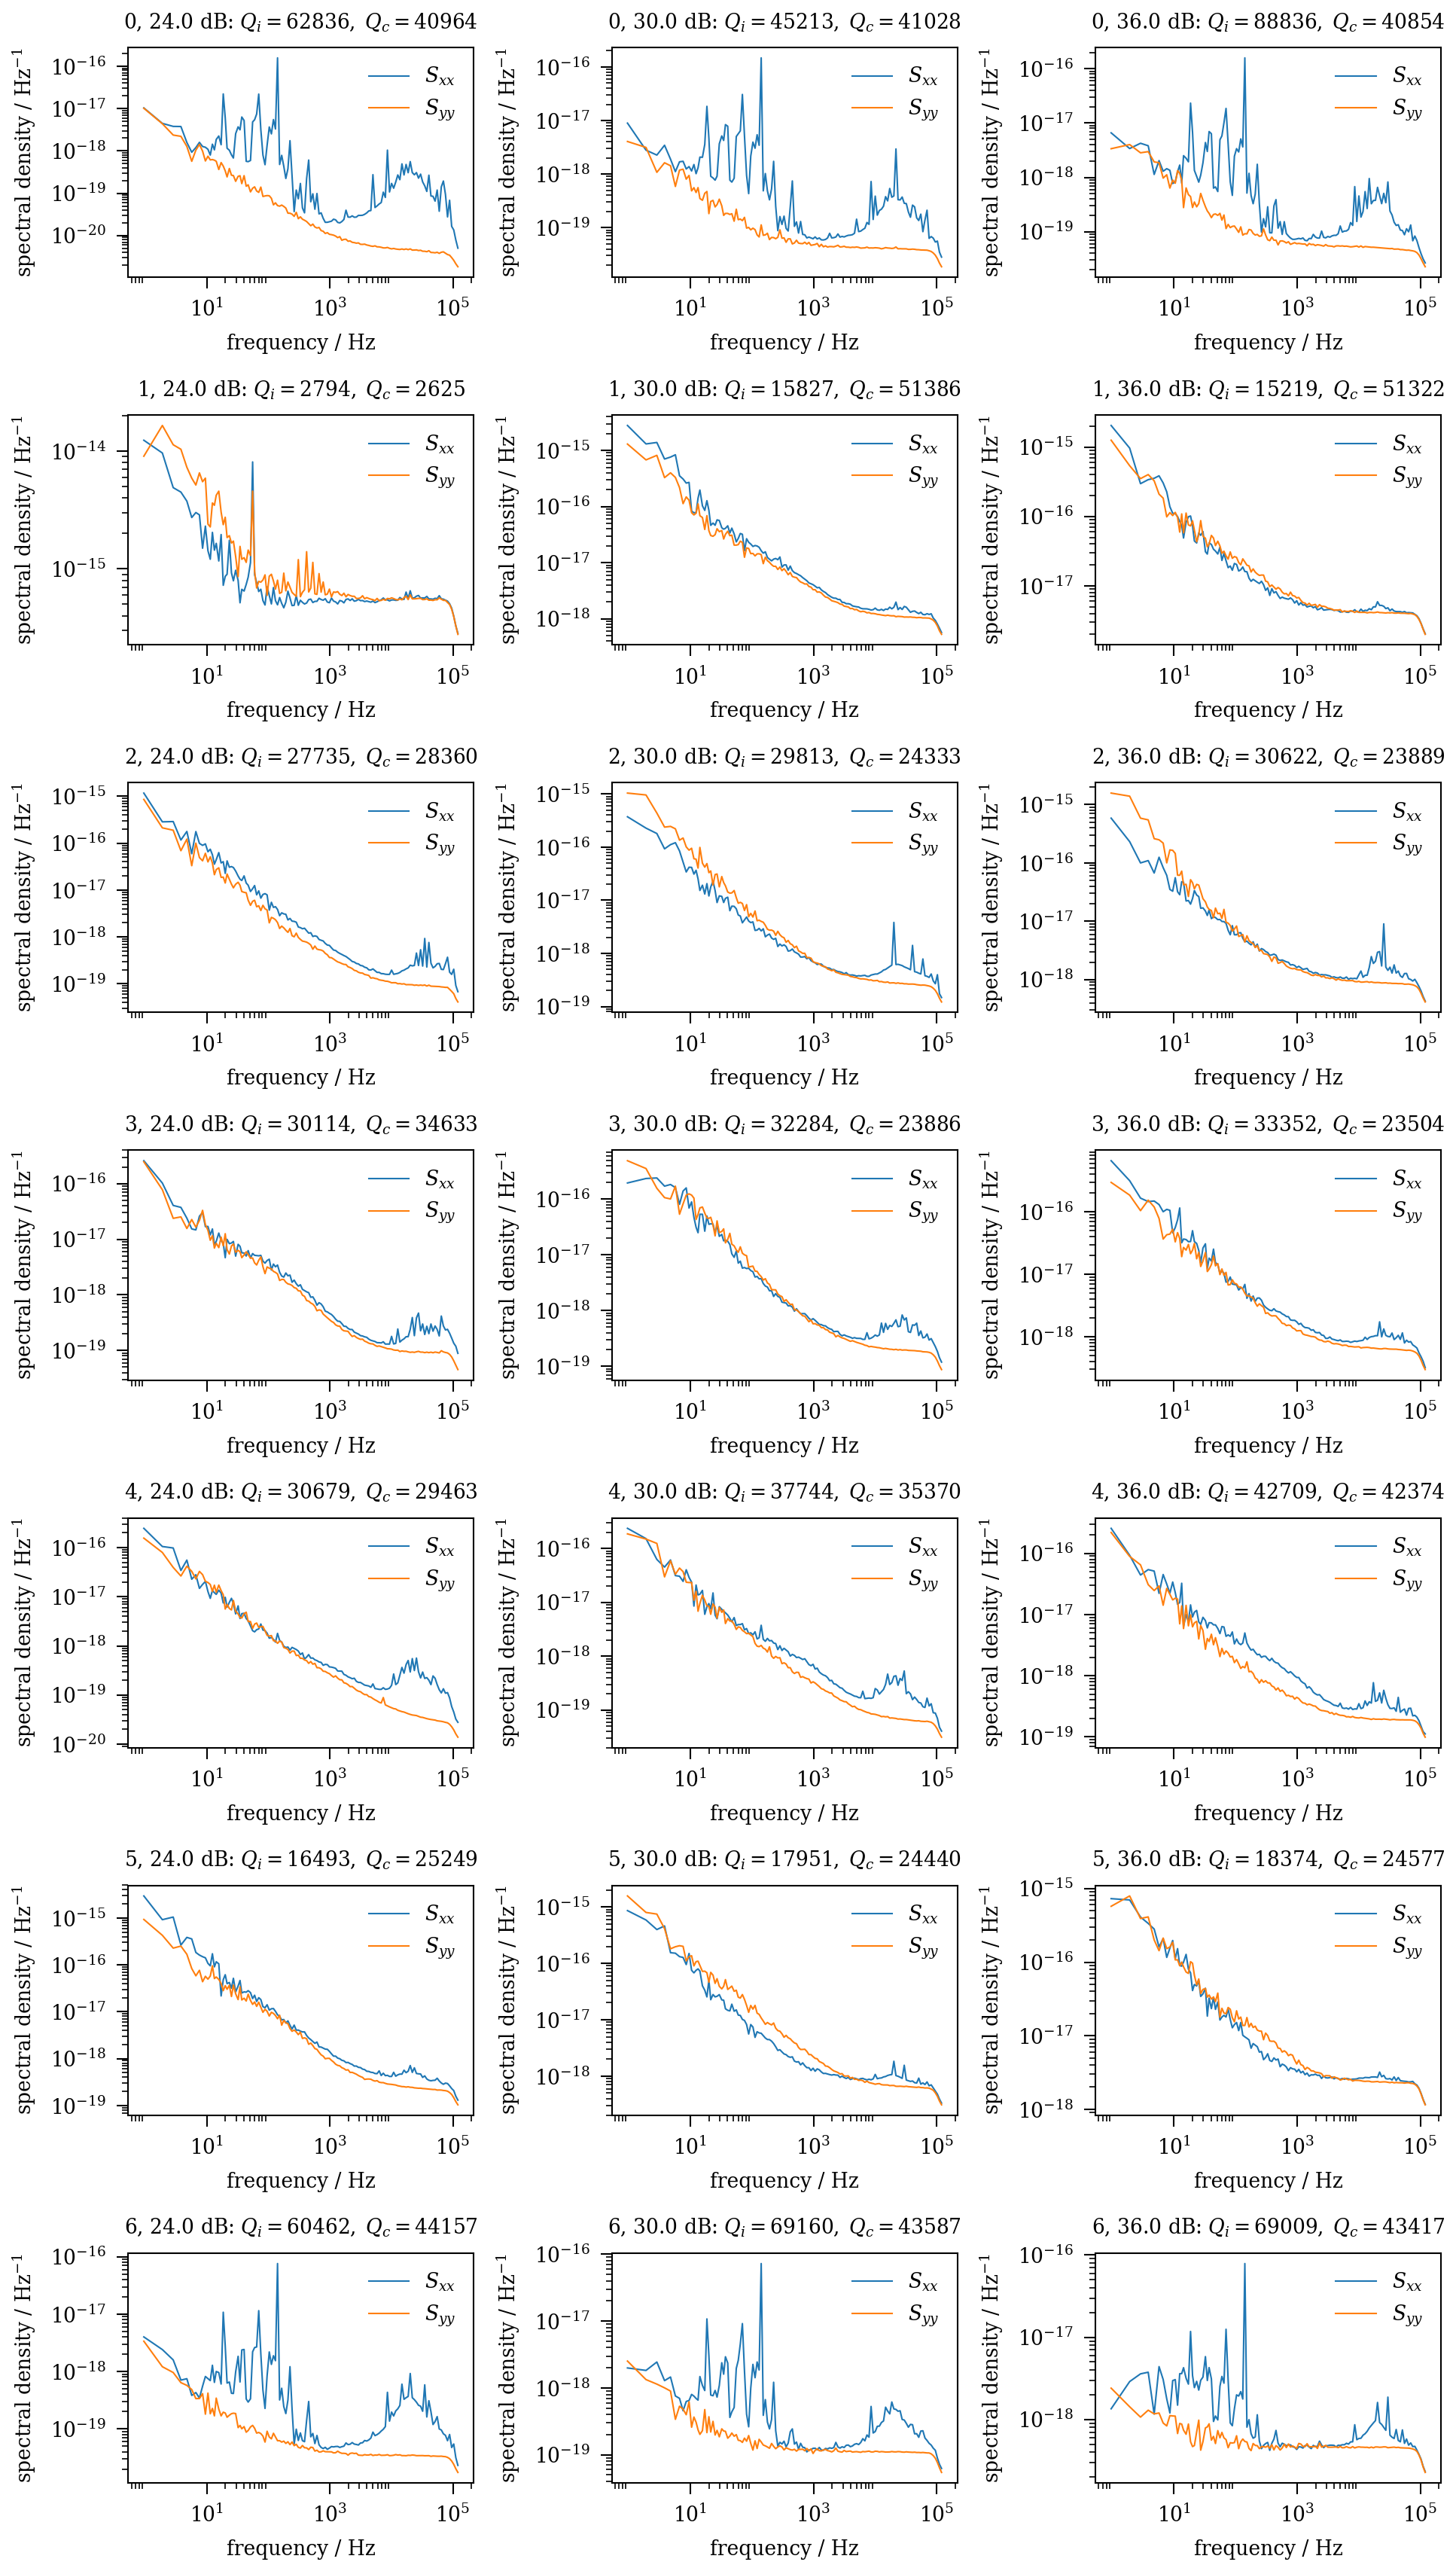

In [15]:
fig, axes = plt.subplots(len(sss_dict.keys()), num_attenuations,
                         figsize=(2.5 * num_attenuations, 2 * len(sss_dict.keys())),
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
for lo_index in sss_dict.keys():
    for sss, ax in zip(sss_dict[lo_index], axes[lo_index, :]):
        ax.set_xlabel(xx_and_yy['xlabel'], fontsize='xx-small')
        ax.set_ylabel(xx_and_yy['ylabel'], fontsize='xx-small')
        ax.set_title(xx_and_yy['title'].format(lo_index, sss.stream.roach_state.dac_attenuation, 
                                               sss.resonator.Q_i, sss.resonator.Q_e_real),
                     fontsize='xx-small')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot(sss.S_frequency, sss.S_xx, label=xx_and_yy['Sxx_label'])
        ax.plot(sss.S_frequency, sss.S_yy, label=xx_and_yy['Syy_label'])
        ax.tick_params(labelsize='xx-small')
        ax.legend(fontsize='xx-small');

# $S_{xx} - S_{yy}$

In [16]:
xx_minus_yy = {'xlabel': 'frequency / Hz',
               'ylabel': 'spectral density / Hz$^{-1}$',
               'title': r'{:d}, {:.1f} dB: $Q_i = {:.0f}, \; Q_c = {:.0f}$',
               'label': '$S_{xx} - S_{yy}$'}

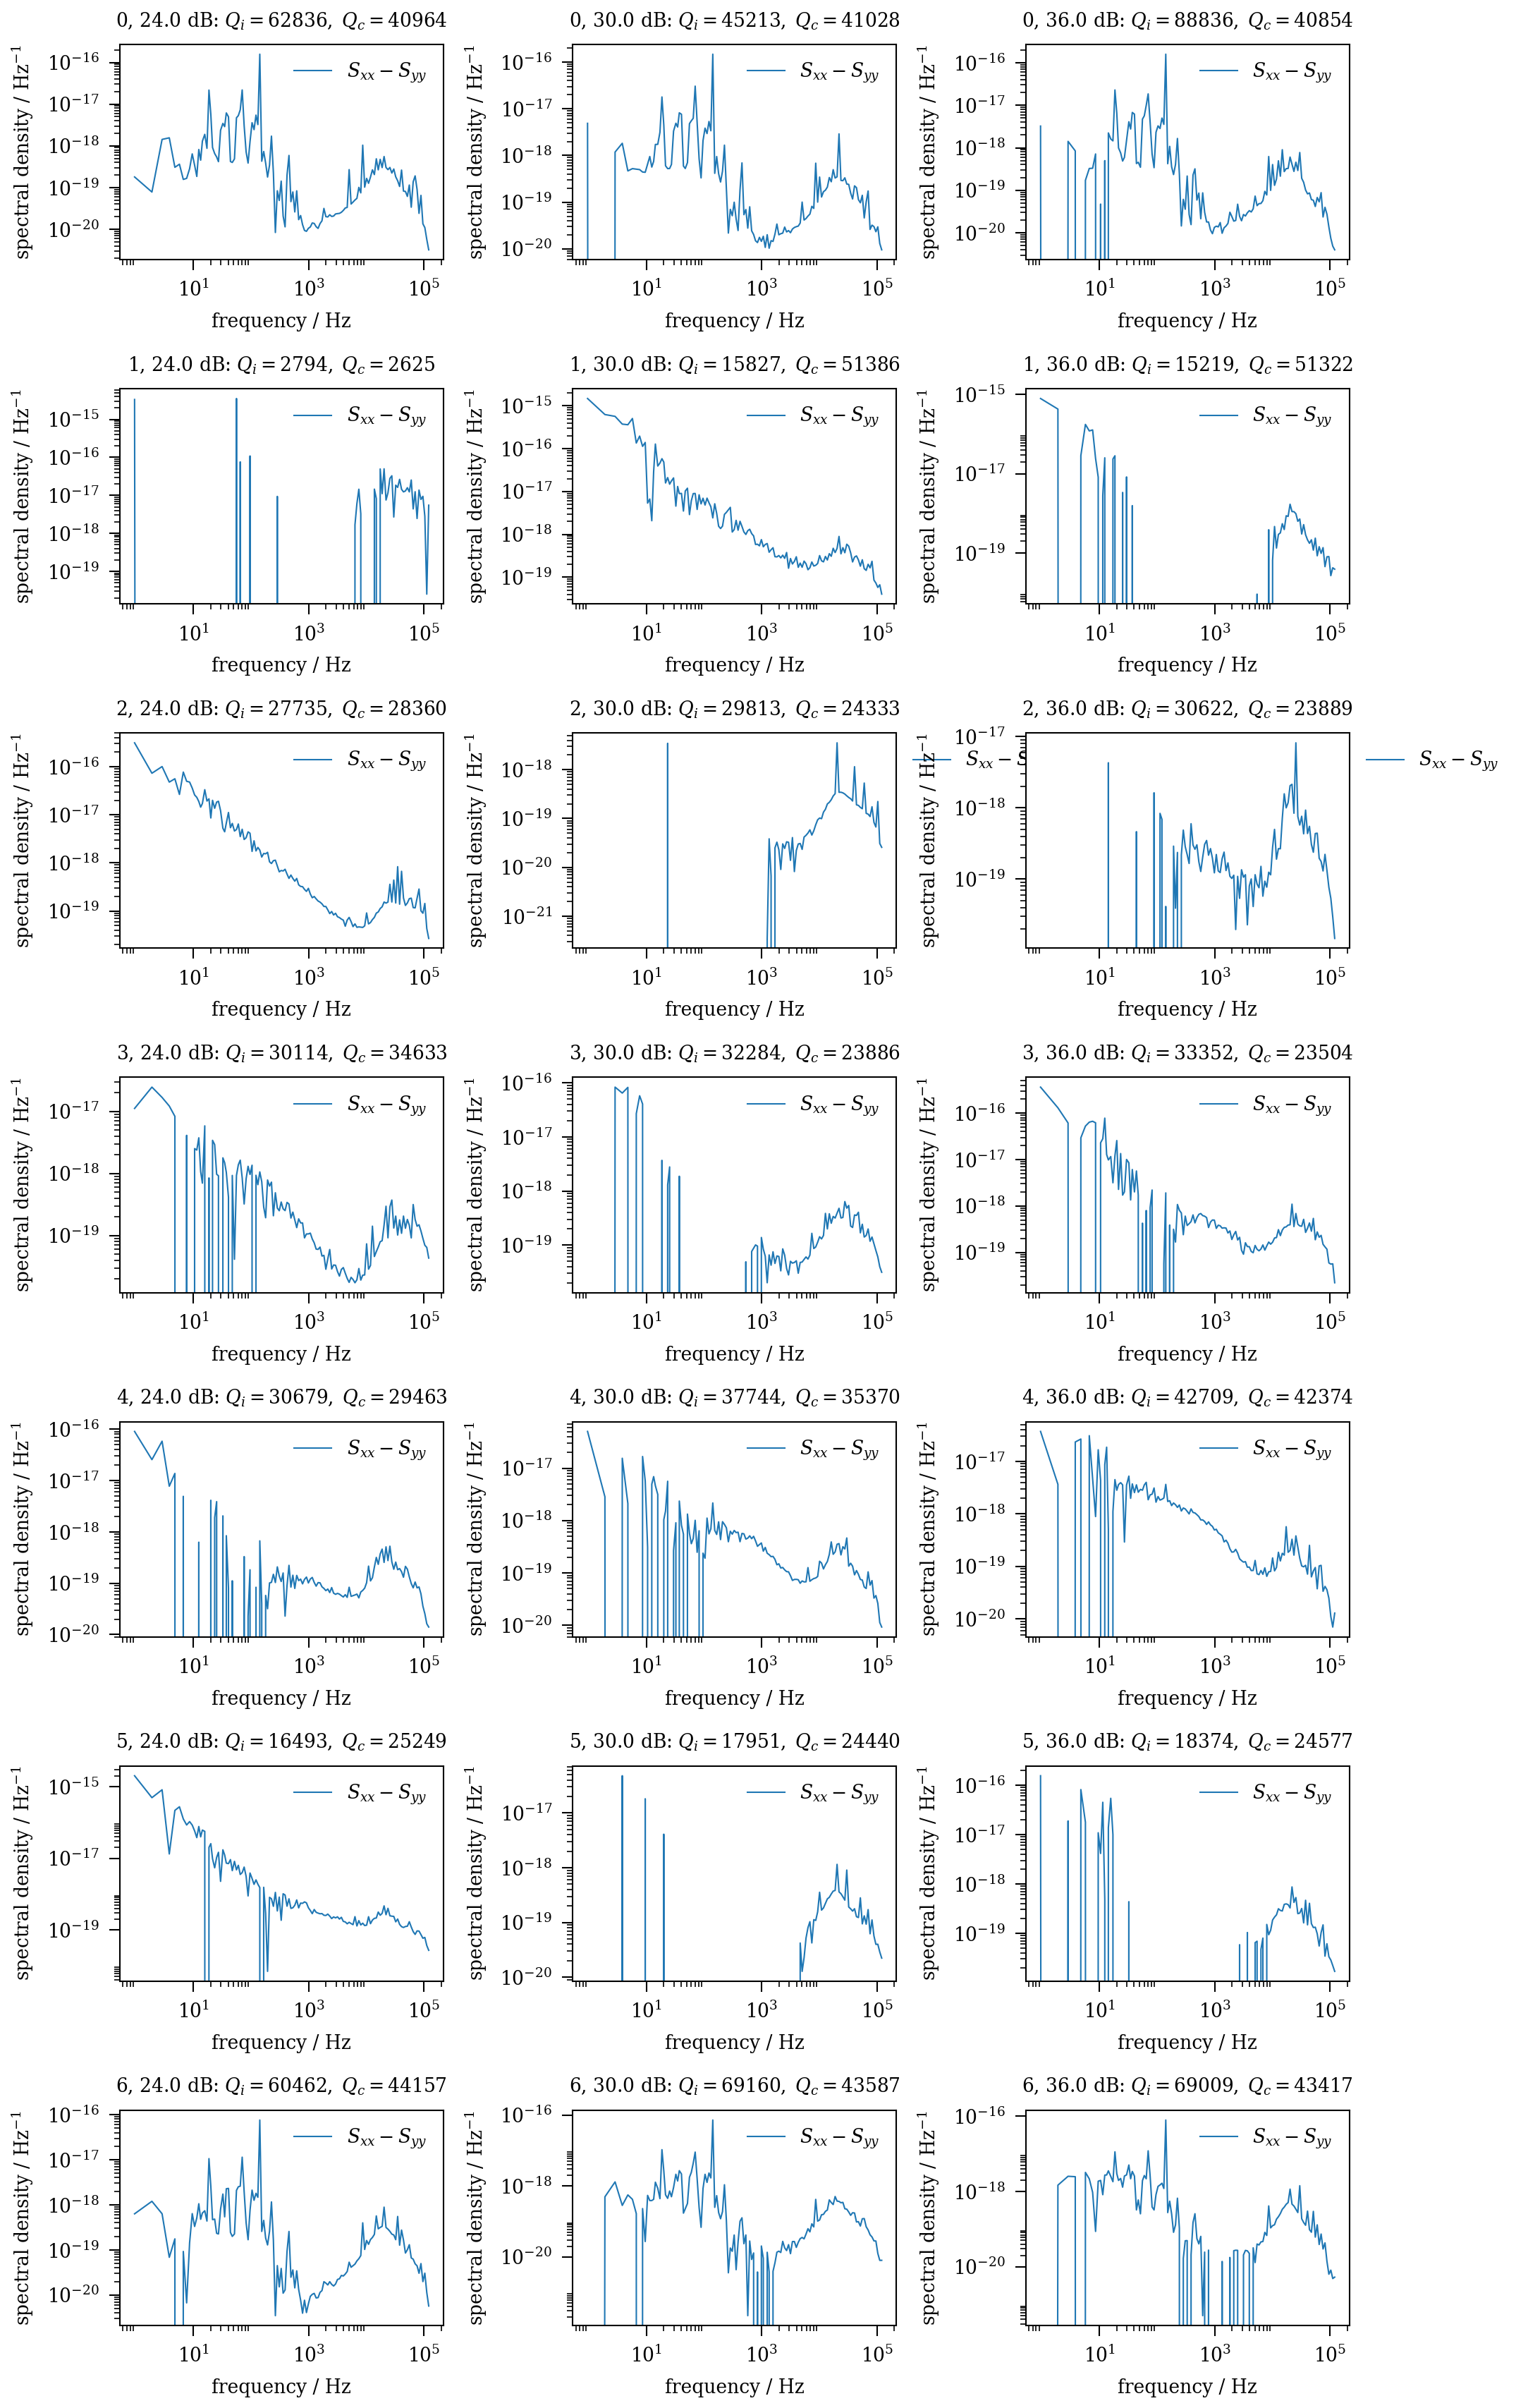

In [17]:
fig, axes = plt.subplots(len(sss_dict.keys()), num_attenuations,
                         figsize=(2.5 * num_attenuations, 2 * len(sss_dict.keys())),
                         gridspec_kw={'wspace': 0.4, 'hspace': 0.6})
for lo_index in sss_dict.keys():
    for sss, ax in zip(sss_dict[lo_index], axes[lo_index, :]):
        ax.tick_params(labelsize='xx-small')
        ax.set_xlabel(xx_and_yy['xlabel'], fontsize='xx-small')
        ax.set_ylabel(xx_and_yy['ylabel'], fontsize='xx-small')
        ax.set_title(xx_and_yy['title'].format(lo_index, sss.stream.roach_state.dac_attenuation, 
                                               sss.resonator.Q_i, sss.resonator.Q_e_real),
                     fontsize='xx-small')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot(sss.S_frequency, sss.S_xx - sss.S_yy, label=xx_minus_yy['label'])
        ax.legend(fontsize='xx-small', ncol=1, bbox_to_anchor=(1, 1));